In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import sys
import itertools
import os
from itertools import groupby
from random import sample

warnings.simplefilter('ignore', pd.errors.DtypeWarning)
np.seterr(divide='ignore')
warnings.simplefilter("ignore")

sys.path.append('/sise/home/shakarch/muscle-formation-regeneration')
sys.path.append(os.path.abspath('..'))

import analysis.calc_single_cell_properties as calculator 
import analysis.calc_auc_over_time as auc_calculator 
import analysis.utils as utils
import data_layer.utils as data_utils
from configuration import consts

%load_ext autoreload
%autoreload 2

## data loading - differentiation scores dataframes

In [2]:
scores_df_s3 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (1,5) + fr"df_score_vid_num_S3.pkl",
                              scores_intensity_path=consts.intensity_model_path % (1,5) + fr"df_score_vid_num_S3.pkl")

scores_df_s2 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (1,5) + fr"df_score_vid_num_S2.pkl",
                              scores_intensity_path=consts.intensity_model_path % (1,5) + fr"df_score_vid_num_S2.pkl")

scores_df_s5 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (2,3) + fr"df_score_vid_num_S5.pkl",
                              scores_intensity_path=consts.intensity_model_path % (2,3) + fr"df_score_vid_num_S5.pkl")

scores_df_s1 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (2,3) + fr"df_score_vid_num_S1.pkl",
                              scores_intensity_path=consts.intensity_model_path % (2,3) + fr"df_score_vid_num_S1.pkl")

In [3]:
scores_df_s3 = calculator.get_properties(scores_df_s3, vid_name="S3", actin_vid_path=consts.vid_info_dict["3"]['actin_path'])
scores_df_s2 = calculator.get_properties(scores_df_s2, vid_name="S2", actin_vid_path=consts.vid_info_dict["2"]['actin_path'])
scores_df_s5 = calculator.get_properties(scores_df_s5, vid_name="S5", actin_vid_path=consts.vid_info_dict["5"]['actin_path'])
scores_df_s1 = calculator.get_properties(scores_df_s1, vid_name="S1", actin_vid_path=consts.vid_info_dict["1"]['actin_path'])

## Analyse single cells speed & actin intensity

### Speed

S3 video (ERK)

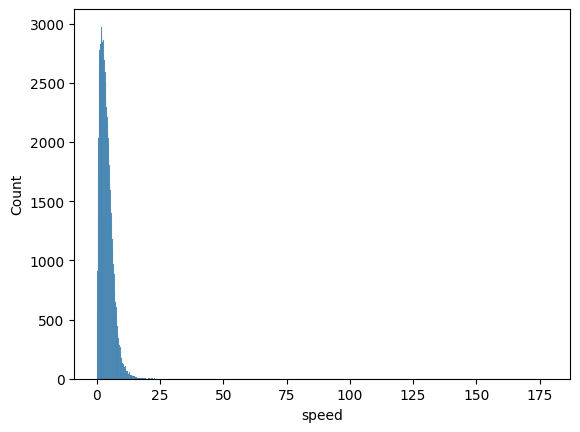

In [4]:
sns.histplot(data=scores_df_s3, x="speed")
plt.show()

In [5]:
def plot_single_cell_property(scores_df, ids_to_plot, property_name, rolling_w=12, plot_mean=True, color="gray", cell_id=""):
    
    for track_id, track in scores_df[scores_df['Spot track ID'].isin(ids_to_plot)].groupby(['Spot track ID']):
        plt.plot(track["time"].rolling(rolling_w).mean(), track[property_name].rolling(rolling_w).mean(), linewidth=0.2, color=color)
    
    if plot_mean:
        plt.plot(scores_df.dropna(subset=[property_name]).groupby("time")[property_name].mean().rolling(rolling_w).mean())
    plt.grid(False)
    plt.xlabel("time")
    plt.ylabel(property_name)
#     x = track["time"].rolling(rolling_w).mean()
#     plt.xticks(np.arange(0, 24, 10))
    plt.savefig(consts.storage_path + f"eps_figs/tracked_cells_speed_actin/{property_name} over time cell {cell_id}.eps", format="eps")
    plt.show()

    print(f"Number of cells in this analysis: ", len(ids_to_plot))
    
    
def plot_property_over_time(df, label, color, feature, time=(0,25)):
    df = df[(df["time"]>= time[0]) & (df["time"]< time[1])]
    df = df.sort_values("time")
    mean = round(df.dropna(subset=[feature]).groupby("time")[feature].mean(), 2).rolling(1).mean()
    std = round(df.dropna(subset=[feature]).groupby("time")[feature].std(), 2).rolling(1).mean()
    plt.grid(False)
    plt.plot(mean, color=color, label=label)
    plt.fill_between(df["time"].unique()[:len(mean)], mean - std, mean + std, alpha=0.4, color=color, label=label)

    plt.axvspan(6, 13, alpha=0.3, color='lightgray')
    plt.axvline(6, color='gray', linestyle='dashed')
    plt.axvline(13, color='gray', linestyle='dashed')

    plt.ylabel(feature)
    plt.xlabel("time")
    x = df["time"].unique()[:len(mean)]
    plt.xticks(np.arange(x.min(), x.max(), 10))

    plt.title(f'{feature} over time')
    
    plt.legend()
    plt.savefig(consts.storage_path + f"eps_figs/tracked_cells_speed_actin/{feature} over time.eps", format="eps")
    plt.show()

speed ranges between 0 and 15 um/5 min, with several outliars due to technical problems in tracking 
(missing spot within the track can cause a biased speed, for example)
We will now remove them to clean our data.

we removed 14.799999999999999% of the tracked cells


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


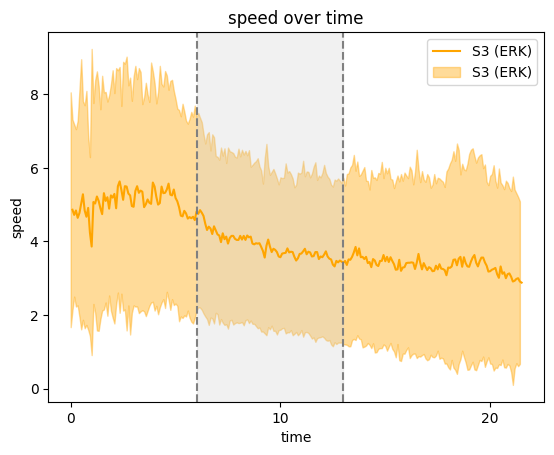

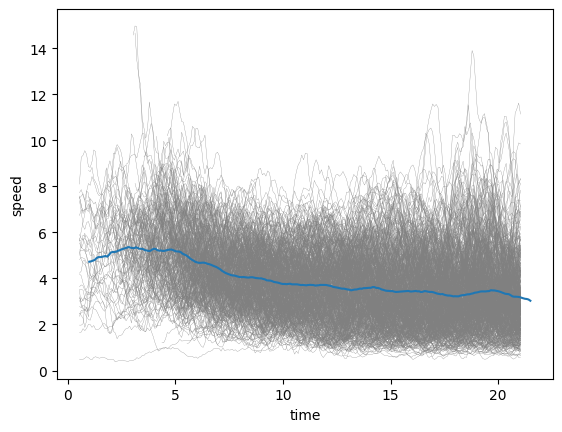

Number of cells in this analysis:  575


In [6]:
ids_to_plot = utils.remove_speed_outlaiers(scores_df_s3, speed_threshold=50)   
plot_property_over_time(scores_df_s3[scores_df_s3["Spot track ID"].isin(ids_to_plot)], "S3 (ERK)","orange", "speed")
plot_single_cell_property(scores_df_s3, ids_to_plot, "speed", rolling_w=12, cell_id="all")

lets sample some single cells to plot

22635


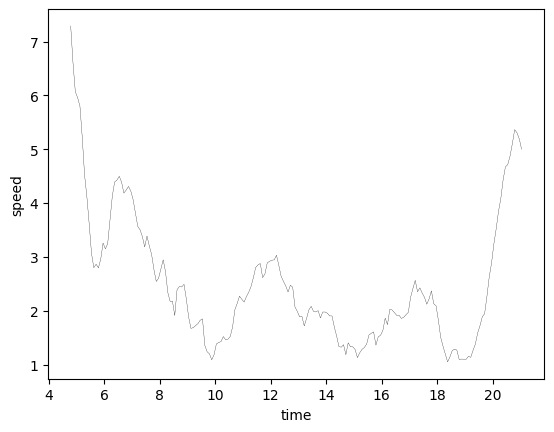

Number of cells in this analysis:  1
22636


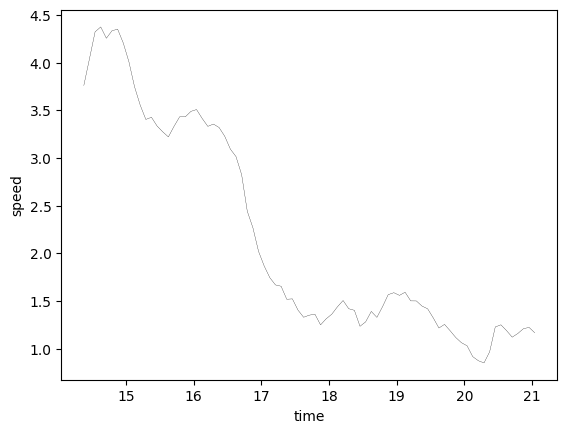

Number of cells in this analysis:  1
18542


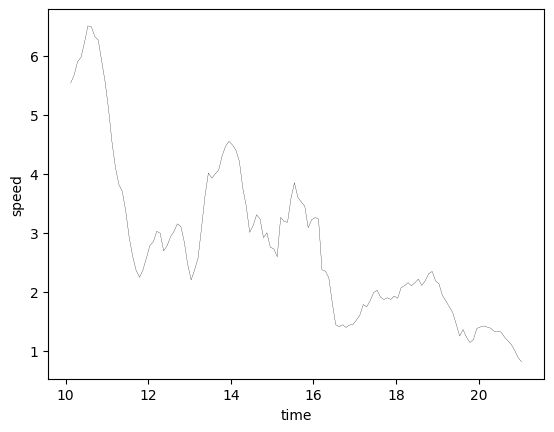

Number of cells in this analysis:  1
16497


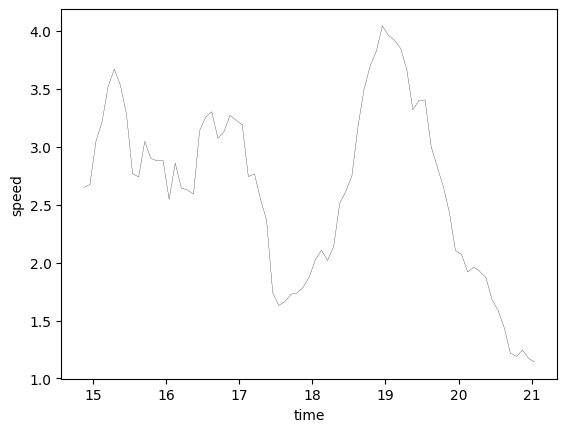

Number of cells in this analysis:  1
20601


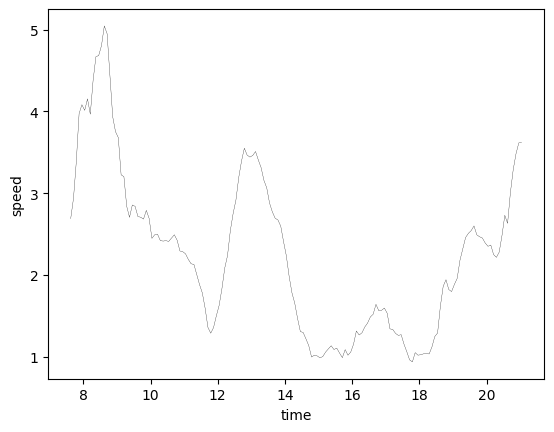

Number of cells in this analysis:  1
12412


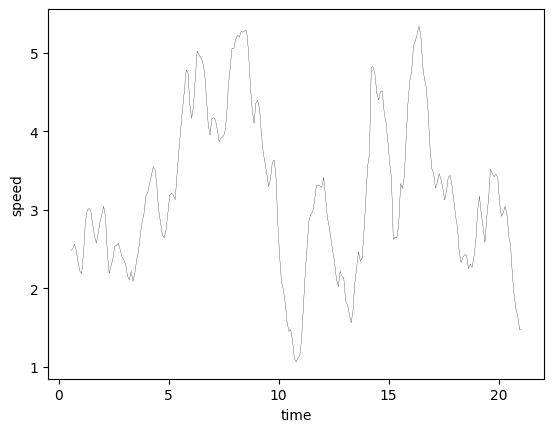

Number of cells in this analysis:  1
20609


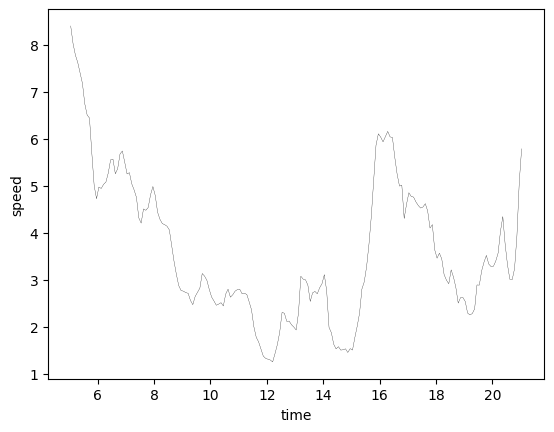

Number of cells in this analysis:  1
16519


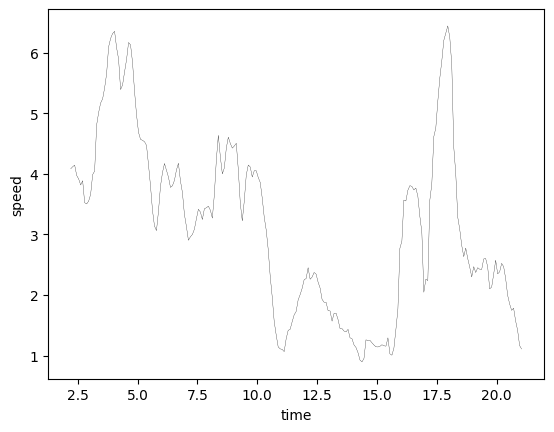

Number of cells in this analysis:  1
8329


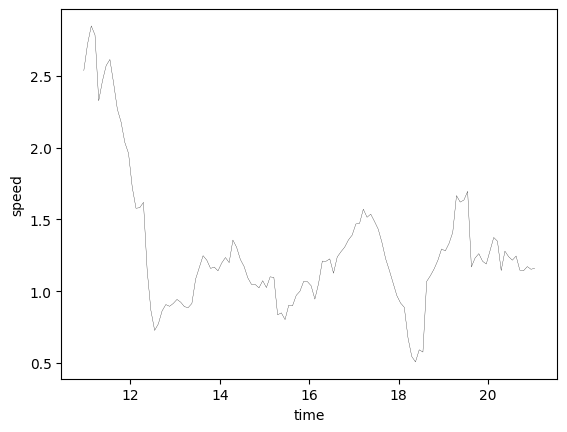

Number of cells in this analysis:  1
2193


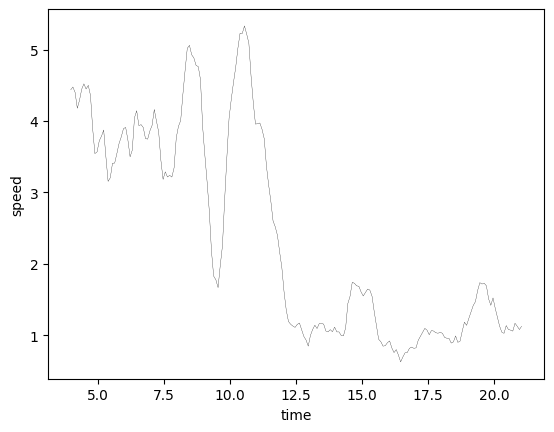

Number of cells in this analysis:  1


In [68]:
for track_id in list(ids_to_plot)[20: 30]: # [29204, 8598, 8198, 28754, 22636, 18542]
    print(track_id)
    plot_single_cell_property(scores_df_s3, [track_id], "speed", rolling_w=12, plot_mean=False, color="black", cell_id=track_id)

S5 video (ERK)

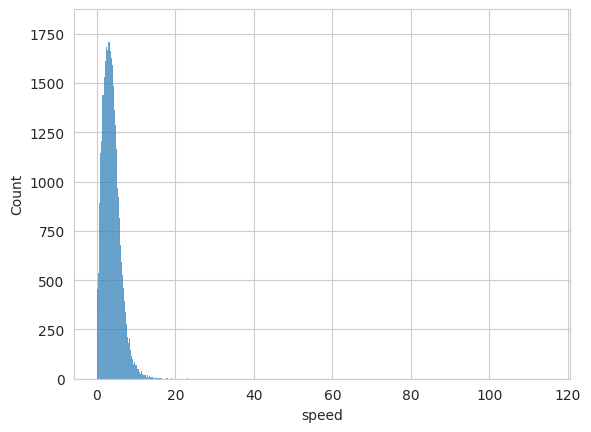

In [44]:
sns.histplot(data=scores_df_s5, x="speed")
plt.show()

we removed 27.1% of the tracked cells


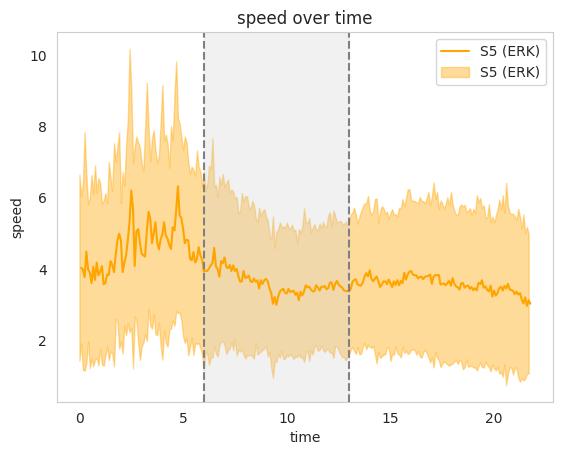

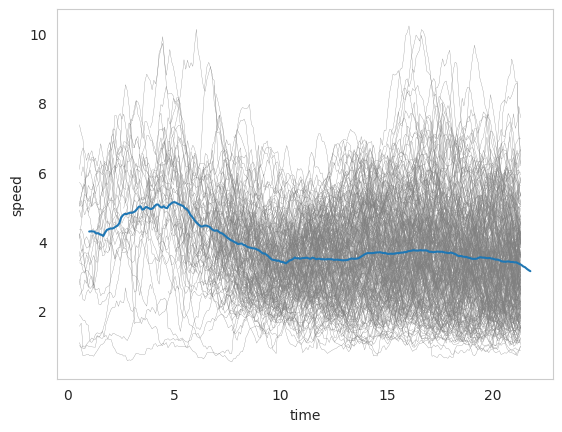

Number of cells in this analysis:  307


In [49]:
ids_to_plot = remove_speed_outlaiers(scores_df_s5, speed_threshold=30)   
plot_property_over_time(scores_df_s5[scores_df_s5["Spot track ID"].isin(ids_to_plot)], "S5 (ERK)","orange", "speed")
plot_single_cell_property(scores_df_s5, ids_to_plot, "speed", rolling_w=12)

### Actin intensity (mean)

S3 video (ERK)

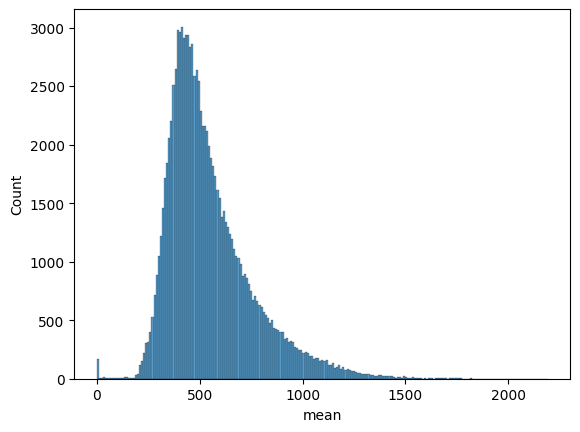

In [38]:
sns.histplot(data=scores_df_s3, x="mean")
plt.show()

mean actin intensity ranges between <0 and ~2000, with several outliars.
We will now remove them to clean our data.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


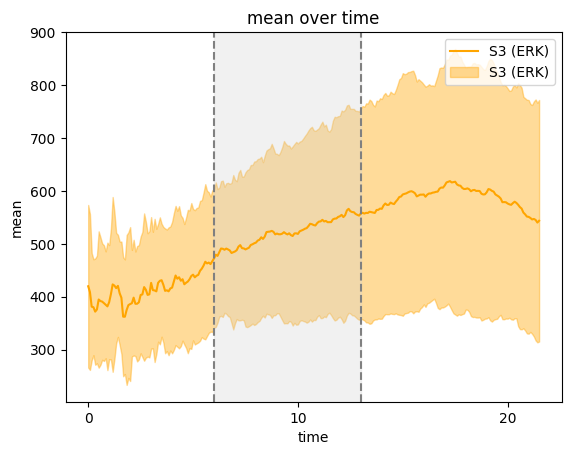

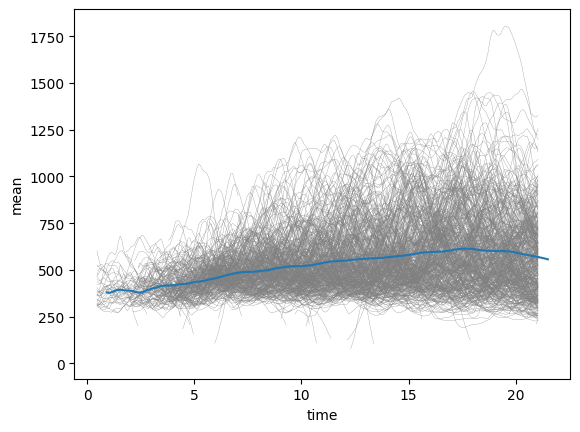

Number of cells in this analysis:  575


In [20]:
plot_property_over_time(scores_df_s3[scores_df_s3["Spot track ID"].isin(ids_to_plot)], "S3 (ERK)","orange", "mean")
plot_single_cell_property(scores_df_s3, ids_to_plot, "mean", rolling_w=12)

In [12]:
# remove outlaiers
 
def remove_mean_actin_outlaiers(scores_df, low_threshold, high_threshold):
    """
    """
    
    track_ids_mean = set(scores_df[(scores_df["mean"] > low_threshold) & (scores_df["mean"] < high_threshold)]['Spot track ID'].unique())
    
    removed_tracks_num = scores_df['Spot track ID'].nunique() - len(track_ids_mean)
    fraction = round(removed_tracks_num/scores_df['Spot track ID'].nunique(),3)

    print(f"we removed {fraction * 100}% of the tracked cells")
    
    return track_ids_mean

S5 video (ERK)

10472


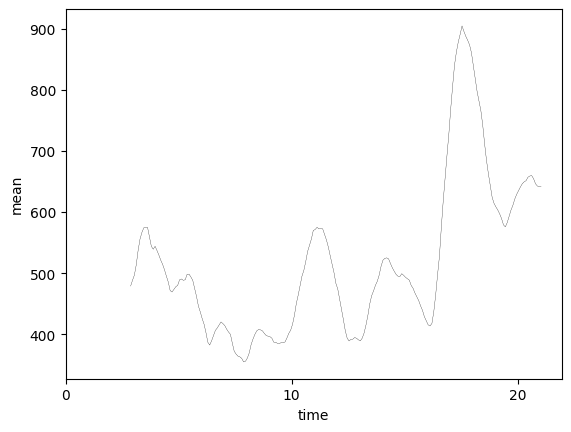

Number of cells in this analysis:  1
12526


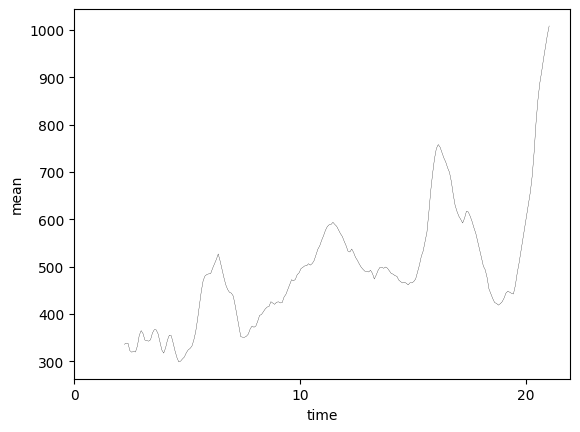

Number of cells in this analysis:  1
10483


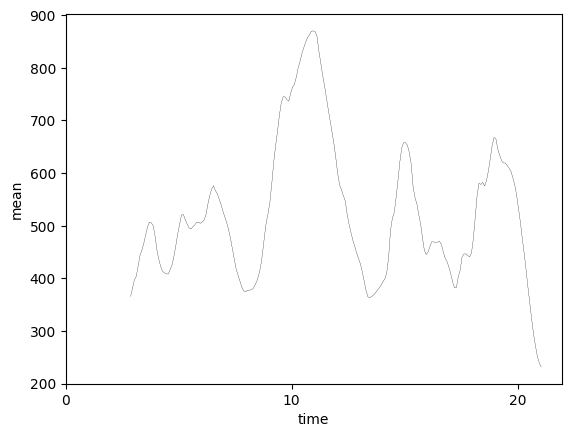

Number of cells in this analysis:  1
8435


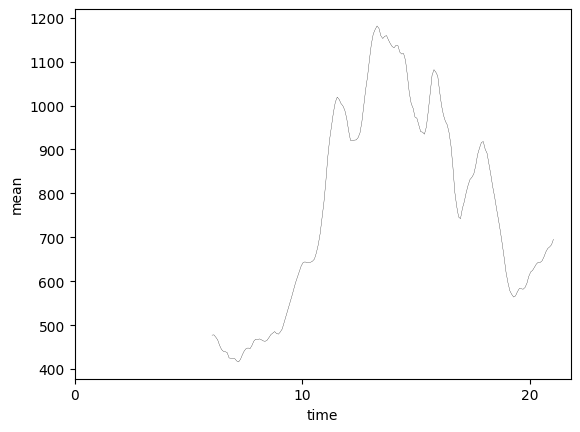

Number of cells in this analysis:  1
8443


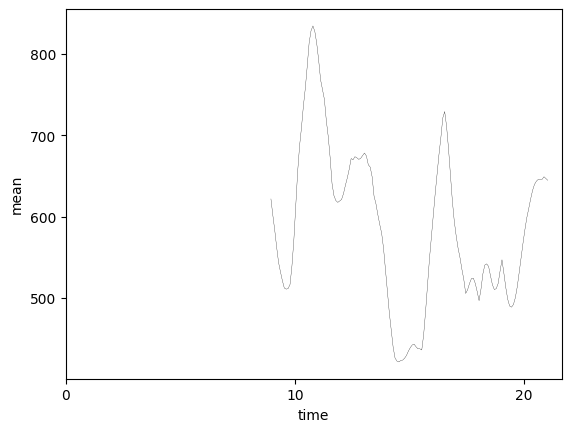

Number of cells in this analysis:  1
8445


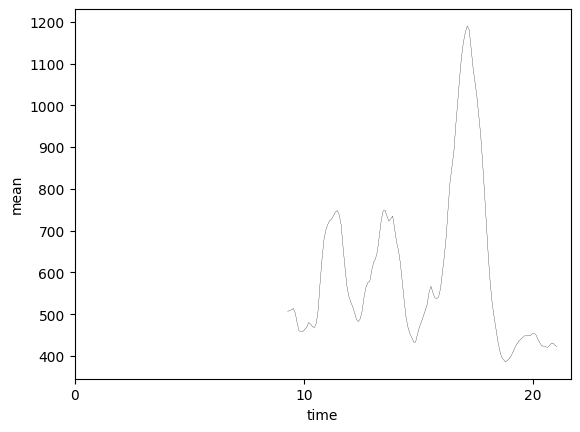

Number of cells in this analysis:  1
18687


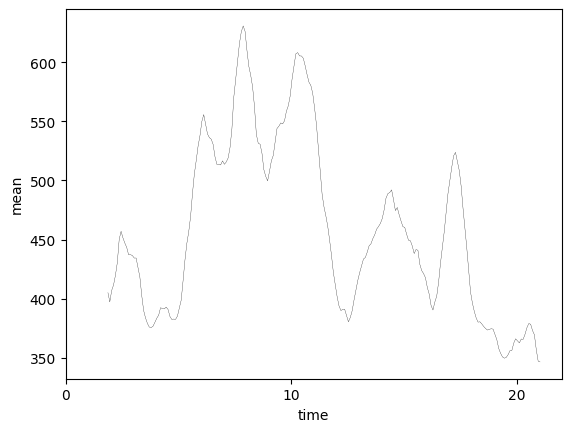

Number of cells in this analysis:  1
6401


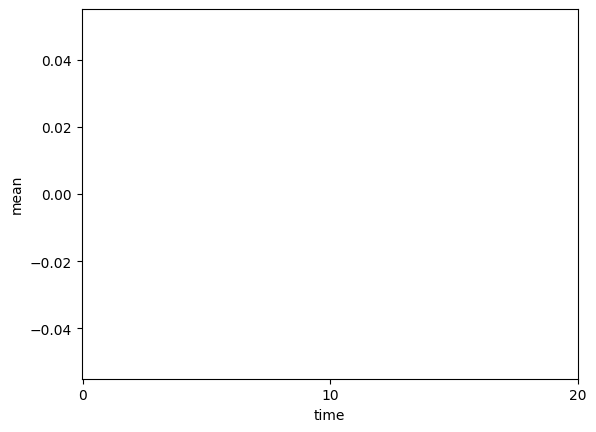

Number of cells in this analysis:  1
4356


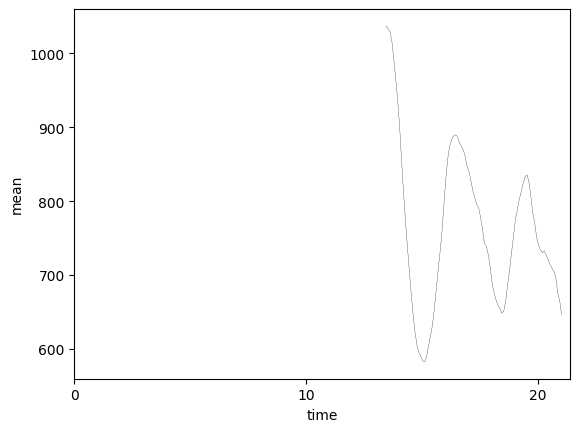

Number of cells in this analysis:  1
6405


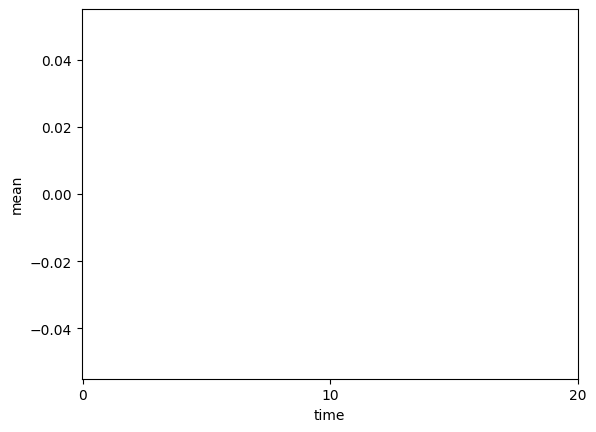

Number of cells in this analysis:  1


In [65]:
for track_id in list(ids_to_plot)[50: 60]:
    print(track_id)
    plot_single_cell_property(scores_df_s3, [track_id], "mean", rolling_w=12, plot_mean=False, color="black", cell_id=track_id)

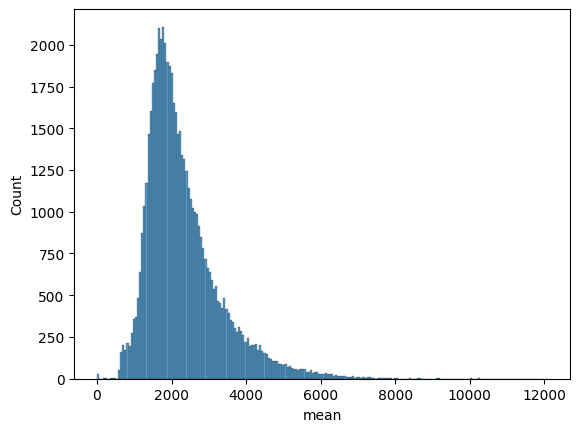

In [12]:
sns.histplot(data=scores_df_s5, x="mean")
plt.show()

we removed 1.4000000000000001% of the tracked cells


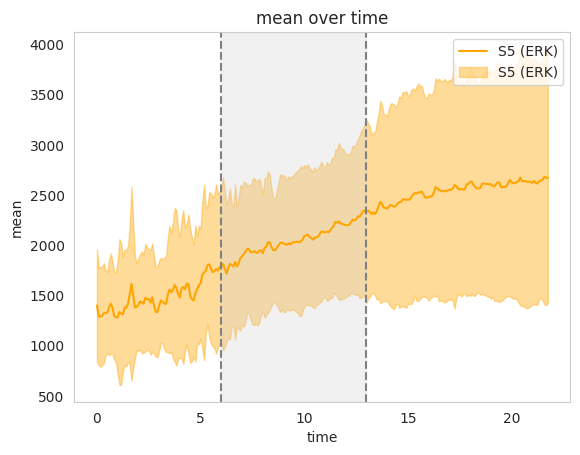

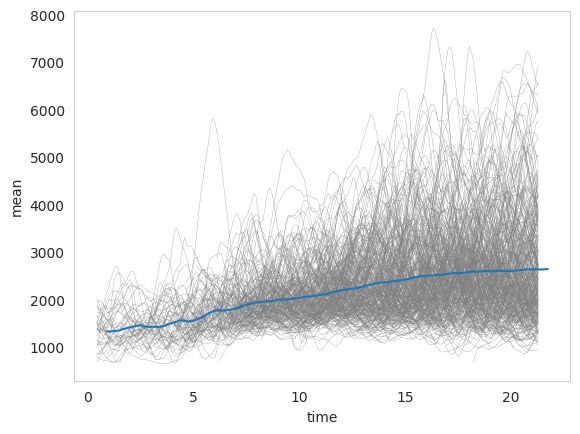

Number of cells in this analysis:  414


In [51]:
ids_to_plot = remove_mean_actin_outlaiers(scores_df_s5, 0, 10000)
plot_property_over_time(scores_df_s5[scores_df_s5["Spot track ID"].isin(ids_to_plot)], "S5 (ERK)","orange", "mean")
plot_single_cell_property(scores_df_s5, ids_to_plot, "mean", rolling_w=12)